# Joint seismic interpolation and deghosting with Deep Preconditioners

## Author: M.Ravasi

This notebook presents an example of Deep Preconditioned inversion for seismic applications, more specifically to `interpolate and deghost` seismic shot gathers. 

After a representation model is trained (see `Syncline_deghosting_pl`), deghosting can be quickly applied on any shot gather of interest here.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pylops

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt, convolve
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from torchsummary import summary
from pytorch_lightning import seed_everything

from pylops.utils import dottest
from pylops.utils.wavelets import *
from pylops.utils.tapers import *
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.oneway import PhaseShift, Deghosting
from pylops.optimization.sparsity  import *
from pylops_gpu import TorchOperator

from deepprecs.ghost import deghosting
from deepprecs.patching import patching, patch_scalings, patch2d_design
from deepprecs.subsampling import subsampling 
from deepprecs.aemodel import AutoencoderBase, AutoencoderRes, AutoencoderMultiRes
from deepprecs.train_pl import *
from deepprecs.invert import InvertAll

## Parameters

In [2]:
################# GLOBAL ####################
# Device
devicenum = 0
device = torch.device(f"cuda:{devicenum}" if torch.cuda.is_available() else "cpu")
print(device)
if 'cuda' in str(device):
    import cupy as cp

# Seed
seed_everything(5)

# Input filepath
inputfile = '../../data/syncline/input.npz'

# Model and figure directories
label = 'syncline'
outputmodels = f'../../models/{label}'
outputfigs = f'../../figures/{label}'

################# TRAINING ####################

# Patches
nspatch, ntpatch = 64, 64
nsjump, ntjump = 32, 32

# Experiment number and name
iexp = 13
expname = 'ResNet network with more filters 300enc - mse+ccc cost with learned weigths + mask'

# AE parameters
aetype = AutoencoderRes # AE type: AutoencoderBase, AutoencoderRes, AutoencoderMultiRes
nenc = 300 # Size of latent space
kernel_size = 5 # Size of filters kernels
nfilts = 32 # number of filters for conv layers in first level (doubles up going down)
nlayers = 2 # number of layers per level 
nlevels = 2 # number of levels
convbias = True # add bias to convolution layers 
downstride = 1 # stride of downsampling/pooling blocks (same will be used for upsampling blocks)
downmode = 'max' # type of pooling (avg or max)
upmode = 'upsample' # type of upsampling (convtransp, upsample or upsample1d)
bnormlast = True # add batch normalization to the last layer
act_fun = 'LeakyReLU' # activation function for all hidden layers
relu_enc = False # add ReLU activation to the linear layer of the encoder (this and tanh_enc cannot be both true)
tanh_enc = True # add TanH activation to the linear layer of the encoder
relu_dec = True # add ReLU activation to the linear layer of the decoder
tanh_final = False # add TanH activation to the last layer of the network - ensures the output is bounded between [-1, 1]

####### DEGHOSTING AND INTERPOLATION #######
# Source index to be used for inversion
isrc = 50

# Direct wave window
toff = 0.06 # time offset
nsmoothwin = 5 # size of smoothing to apply to window

# Ghost  operator
vel_sep = 1500.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level
nxpad = 20 # size of padding along x-axis prior to applying ghost model
ntaper = 11 # size of spatial taper along-x axis prior to applying ghost model

# Restriction operator
kind = 'irreg'
perc = 0.4

# Patching operator
nwin = (nspatch, ntpatch)
nop = (nspatch, ntpatch)
nover = (19, 8)

INFO: Global seed set to 5


cuda:0


## Load data

Let's start by importing the dataset we are going to use for this example

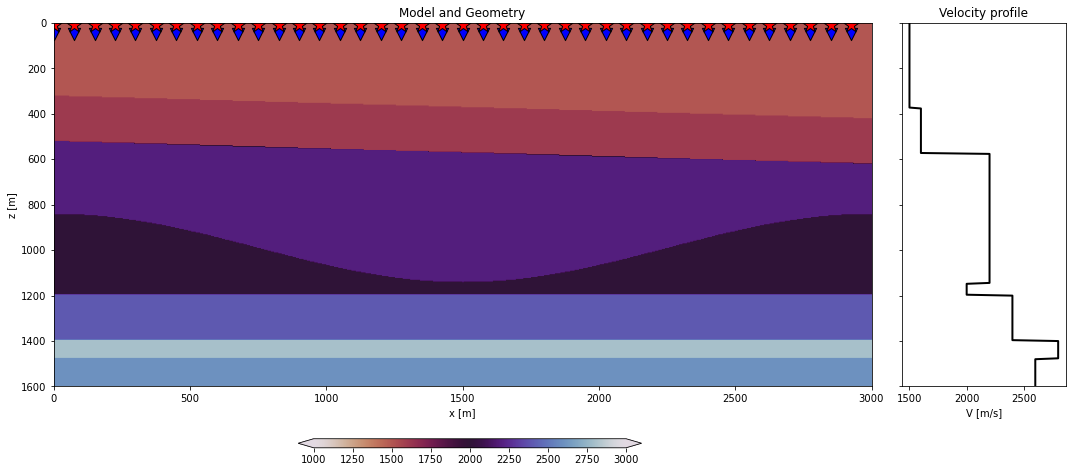

In [3]:
inputdata = np.load(inputfile)

# Receivers
r = inputdata['r'][:, :199]
nr = r.shape[1]
dr = r[0, 1] - r[0, 0]

# Sources
s = inputdata['s'][:, :199]
ns = s.shape[1]

# Model
rho = inputdata['rho']
vel = inputdata['vel']

# Axes
t = inputdata['t']
x, z = inputdata['x'], inputdata['z']
nt, dt = len(t), t[1]-t[0]
dx, dz = x[1] - x[0], z[1] - z[0]

# Load data
p = inputdata['p'][:199, :, :199].transpose(0, 2, 1)
p /= p.max()

# Convolve with wavelet
fwav = 15
wav, _, wav_c = ricker(t[:201], fwav)
p = np.apply_along_axis(convolve, -1, p, wav, mode='full')
p = p[:, :, wav_c:][:, :, :nt]

# Visualize
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True, gridspec_kw={'width_ratios': [5, 1]})
axins1 = inset_axes(axs[0],
                    width="70%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    bbox_to_anchor=(0.125, -0.63, .6, .5),
                    bbox_transform=axs[0].transAxes)
im = axs[0].imshow(vel, extent = (x[0], x[-1], z[-1], z[0]), vmin=1000, vmax=3000, cmap='twilight_r')
axs[0].scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
axs[0].scatter(s[0, ::5], s[1, ::5], marker='*', s=250, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('z [m]')
axs[0].set_title('Model and Geometry')
axs[0].set_xlim(x[0], x[-1])
axs[0].set_ylim(z[-1], z[0])
fig.colorbar(im, cax=axins1, orientation='horizontal', extend="both", fraction=0.046, pad=0.12) 
axs[1].plot(vel[:, len(x)//2], z, 'k', lw=2)
axs[1].set_title('Velocity profile')
axs[1].set_xlabel('V [m/s]')
plt.tight_layout();

## Deghosting problem

Before we start our training process, let's define the ghosting and restriction operators to be used in the subsequent inversion process. 

We will provide our network with such an operator so that later we can apply it directly to the output of its decoder

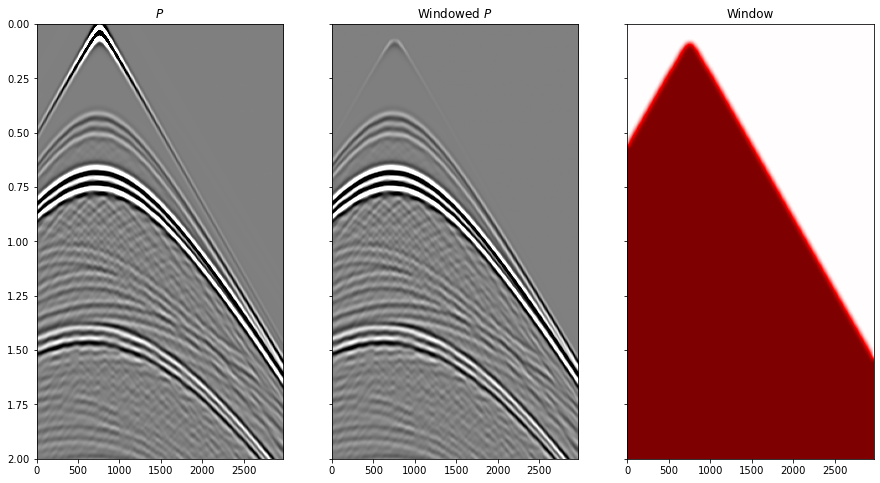

In [4]:
# Ghost operator
win, Dupop = deghosting(s, r, isrc, nt, dt, dz, vel_sep, toff, nsmoothwin, nxpad, ntaper)

# Visualize
clip = 0.05
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 8))
axs[0].imshow(p[isrc].T, cmap='gray', 
              vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent=(r[0, 0], r[0, -1], t[-1], t[0]))
axs[0].set_title(r'$P$')
axs[0].axis('tight')
axs[1].imshow(win * p[isrc].T, cmap='gray', 
              vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent=(r[0, 0], r[0, -1], t[-1], t[0]))
axs[1].set_title(r'Windowed $P$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0)
axs[2].imshow(win, cmap='seismic', vmin=-1, vmax=1,
              extent=(r[0, 0], r[0, -1], t[-1], t[0]))
axs[2].set_title(r'Window')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

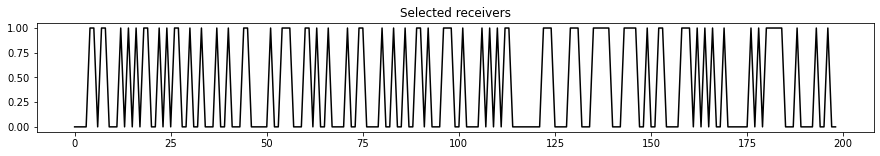

In [5]:
# Restriction operator
iava, mask = subsampling(ns, kind=kind, perc=perc)
Rop = Restriction(ns*nt, iava, dims=(ns, nt), dir=0, dtype='float32')

plt.figure(figsize=(15, 2))
plt.plot(mask, 'k')
plt.title('Selected receivers');

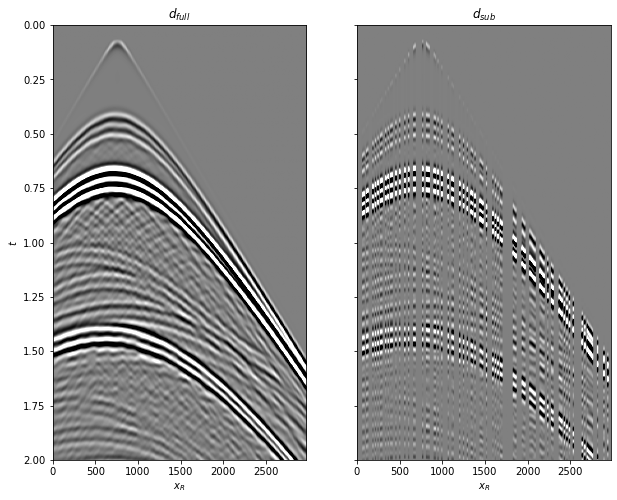

In [6]:
# Create full  and masked data
dfull = win.T * p[isrc] 
d = Rop * dfull.ravel()

dmask = Rop.H * d
dmask = dmask.reshape(nr, nt)

# Convert data to torch
d_torch = torch.from_numpy(d.astype(np.float32)).to(device)
dmask_torch = torch.from_numpy(dmask.astype(np.float32)).to(device)

# Visualize
clip = 0.2
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 8))
axs[0].imshow(dfull.T, cmap='gray',  
              vmin=-clip*np.abs(dfull).max(), vmax=clip*np.abs(dfull).max(), 
              extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$d_{full}$')
axs[0].set_xlabel(r'$x_R$')
axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(dmask.T, cmap='gray', 
              vmin=-clip*np.abs(dfull).max(), vmax=clip*np.abs(dfull).max(),
              extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$d_{sub}$')
axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);

  960 1024]
  960 1024]


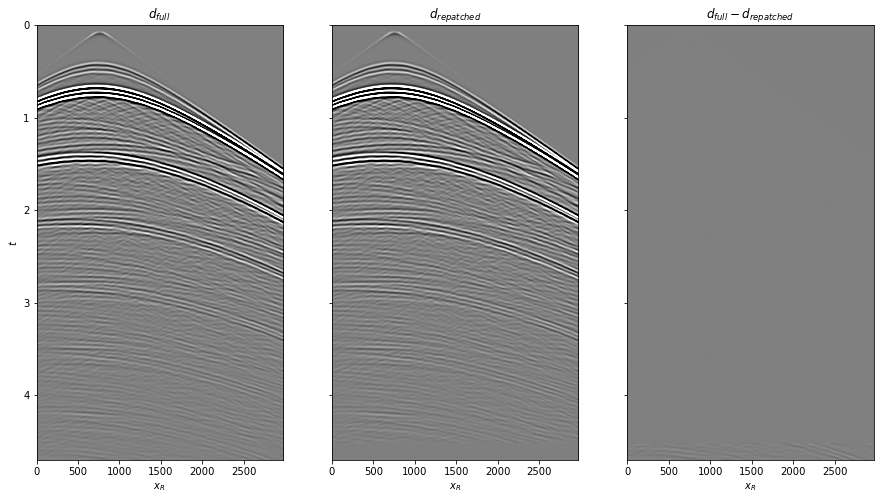

In [7]:
# Patch operator
dimsd = (ns, nt)
npatches = patch2d_design(dimsd, (nspatch, ntpatch), nover, nop)[0]
dims = (npatches[0]*nspatch, npatches[1]*ntpatch)

Op = Identity(nspatch*ntpatch, dtype='float32')
Pop = Patch2D(Op, dims, dimsd, nwin, nover, nop,
              tapertype=None, design=True)
Pop1 = Patch2D(Op.H, dims, dimsd, nwin, nover, nop,
              tapertype='cosine', design=False)
Pop1_torch = TorchOperator(Pop1, pylops=True, device=device)

# Create patches and revert back
dfull_patches = Pop.H * dfull.ravel()
dfull_patches = dfull_patches.reshape(dims)
dfull_repatched = Pop1 * dfull_patches.ravel()
dfull_repatched = dfull_repatched.reshape(dimsd)

# Visualize
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 8))
axs[0].imshow(dfull.T, cmap='gray',  
              vmin=-clip*np.abs(dfull).max(), vmax=clip*np.abs(dfull).max(), 
              extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$d_{full}$')
axs[0].set_xlabel(r'$x_R$')
axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(dfull_repatched.T, cmap='gray', 
              vmin=-clip*np.abs(dfull).max(), vmax=clip*np.abs(dfull).max(),
              extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$d_{repatched}$')
axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0)
axs[2].imshow(dfull.T-dfull_repatched.T, cmap='gray', 
              vmin=-clip*np.abs(dfull).max(), vmax=clip*np.abs(dfull).max(),
              extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'$d_{full}-d_{repatched}$')
axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');

Scalings tensor([2.7430e-02, 3.8460e-02, 2.2165e-01, 1.8182e-01, 7.6126e-02, 1.0630e-01,
        3.1897e-02, 5.2790e-02, 2.4415e-02, 2.6351e-02, 2.6922e-02, 1.3057e-02,
        1.6672e-02, 1.0344e-02, 1.1659e-02, 1.1659e-02, 2.7430e-02, 3.8460e-02,
        2.2072e-01, 1.8987e-01, 7.6126e-02, 9.2906e-02, 3.1897e-02, 4.2240e-02,
        4.2240e-02, 1.9801e-02, 2.6922e-02, 1.3057e-02, 1.3885e-02, 1.0801e-02,
        1.0123e-02, 1.0123e-02, 1.0000e+00, 2.8730e-02, 1.8004e-01, 1.9714e-01,
        2.0454e-01, 8.7702e-02, 8.9394e-02, 3.8325e-02, 4.7697e-02, 1.8982e-02,
        2.0266e-02, 2.0266e-02, 1.3222e-02, 1.0691e-02, 6.8238e-03, 7.1000e-03,
        1.0000e+00, 1.0000e+00, 5.8602e-04, 1.8919e-01, 2.0454e-01, 1.8377e-01,
        1.0145e-01, 1.1399e-01, 4.7697e-02, 4.7698e-02, 2.0266e-02, 2.2661e-02,
        1.9678e-02, 1.1328e-02, 1.1328e-02, 8.3860e-03], device='cuda:0')


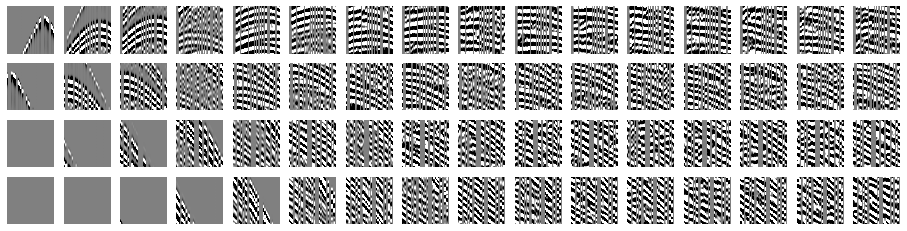

In [8]:
# Find scalings
scalings = patch_scalings(dmask, Pop, npatches, npatch=(nspatch, ntpatch), 
                          plotflag=True, clip=clip, device=device)

In [9]:
# Overall operator
RDupop = Rop * Dupop
RDupop_torch = TorchOperator(RDupop, pylops=True, device=device);

## Deghosting

In [10]:
print('Working with Experiment %d - %s' % (iexp, expname))

# Create directory to save training evolution
figdir = os.path.join(outputfigs, 'exp%d' % iexp)

if figdir is not None:
    if not os.path.exists(figdir):
        os.mkdir(figdir)

# Create model to train
autoencoder = aetype(nh=nspatch, nw=ntpatch, nenc=nenc, 
                     kernel_size=kernel_size, nfilts=nfilts, 
                     nlayers=nlayers, nlevels=nlevels,
                     physics=RDupop_torch, 
                     convbias=convbias, act_fun=act_fun, 
                     downstride=downstride, downmode=downmode,
                     upmode=upmode, bnormlast=bnormlast,  
                     relu_enc=relu_enc, tanh_enc=tanh_enc, 
                     relu_dec=relu_dec, tanh_final=tanh_final,
                     patcher=Pop1_torch, npatches=npatches[0]*npatches[1],
                     patchesscaling=scalings)
autoencoder.load_state_dict(torch.load(os.path.join(outputmodels, 'exp%d_modelweights.pt' % iexp)))
autoencoder.to(device);

Working with Experiment 13 - ResNet network with more filters 300enc - mse+ccc cost with learned weigths + mask


In [11]:
autoencoder.train()
autoencoder.eval()

# Initial guess
patchesmask = Pop.H * dmask.ravel()
patchesmask = patchesmask.reshape(npatches[0]*npatches[1], 1, nspatch, ntpatch)
patchesmask_scaled = patchesmask / scalings.cpu().detach().numpy()
p0 = autoencoder.encode(torch.from_numpy(patchesmask_scaled.astype(np.float32)).to(device)).cpu().detach().numpy()

# Invert
inv = InvertAll(device, # device
                nenc, npatches[0] * npatches[1],
                autoencoder, autoencoder.patched_physics_decode, autoencoder.patched_decode, # modelling ops
                nn.MSELoss(), 1., 80, # optimizer
                reg_ae=0., x0=p0, bounds=None
                )
minv, pinv = inv.scipy_invert(d_torch, torch.zeros(((nr, nt))).to(device))

# Recompute data from minv
if 'cuda' in str(device):
    dinv = cp.asnumpy(Dupop * cp.asarray(minv))
else:
    dinv = Dupop * minv

minv = minv.reshape(ns, nt)
dinv = dinv.reshape(ns, nt)

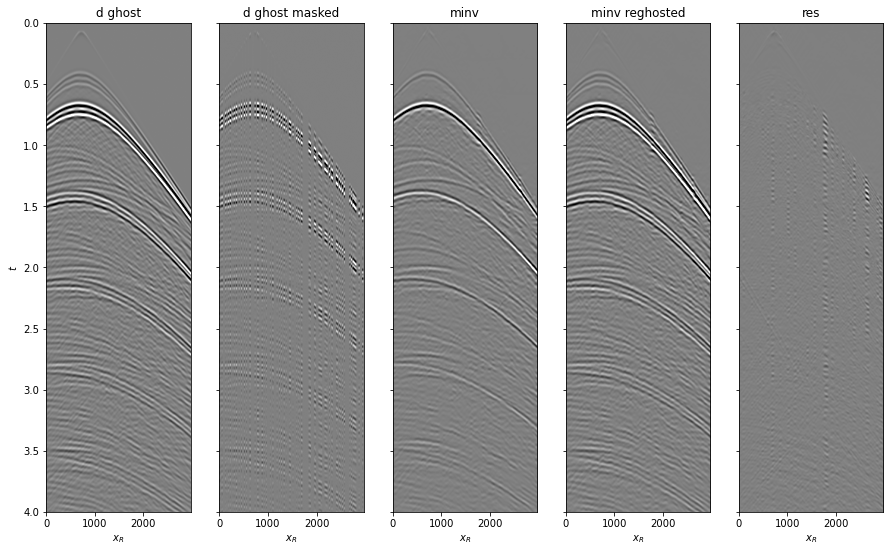

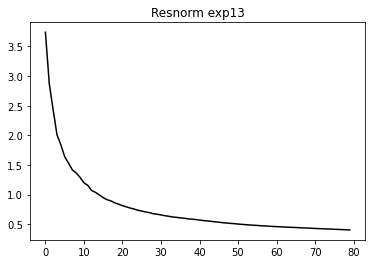

In [12]:
# Visualize
cmax = .2
pad = 4
tgain = np.exp(0.5*t)

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15, 9))
axs[0].imshow(dfull[pad:-pad].T * tgain[:, np.newaxis], cmap='gray', vmin=-cmax, vmax=cmax,
              extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('d ghost')
axs[0].set_xlabel(r'$x_R$')
axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(dmask[pad:-pad].T * tgain[:, np.newaxis], cmap='gray', vmin=-cmax, vmax=cmax,
              extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('d ghost masked')
axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[2].imshow(minv[pad:-pad].T * tgain[:, np.newaxis], cmap='gray', vmin=-cmax, vmax=cmax,
              extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('minv')
axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[3].imshow(dinv[pad:-pad].T * tgain[:, np.newaxis], cmap='gray',  vmin=-cmax, vmax=cmax,
              extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[3].set_title('minv reghosted')
axs[3].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[4].imshow((dfull[pad:-pad].T-dinv[pad:-pad].T ) * tgain[:, np.newaxis], cmap='gray', vmin=-cmax, vmax=cmax,
              extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[4].set_title('res')
axs[4].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(4, 0)
plt.savefig(os.path.join(figdir, f'exp{iexp}_deghosting.png'))

plt.figure()
plt.plot(inv.resnorm, 'k')
plt.title(f'Resnorm exp{iexp}');